# Activity Classification:
- Data from a wearable accelerometer mounted on the chest. Uncalibrated Accelerometer Data are collected from 15 participants and 7 activities. 
- Goal of this challenge is to train and test three classifiers to predict type of activity using provided data. 

## Attributes and and activities:

- Labels are specified as follows:
    
  1. Working at Computer
  2. Standing Up, Walking and Going up\down stairs
  3. Standing
  4. Walking
  5. Going Up\Down Stairs
  6. Walking and Talking with Someone
  7. Talking while Standing

## Challenges with data:
 - Data dictonary lists 7 activities. Since label 0 has very small size compare to others, it make sense to work only on the others labels.
 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import GradientBoostingClassifier as gb
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import seaborn

C:\Users\Somaye\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Loading data

In [3]:
df = pd.DataFrame()
for i,s in enumerate(os.listdir('data')):
    if s.endswith('.csv'):
        df = pd.concat([df, pd.read_csv('data/'+s, names=[ 'sequential number',
                                                          'x acceleration', 
                                                          'y acceleration', 
                                                          'z acceleration', 
                                                          'label'])])
        

In [4]:
# removing label 0, which is not in the library
df = df[df.label != 0]

In [5]:
#Sequential number is highly correlated with label
df.corr()

,sequential number,x acceleration,y acceleration,z acceleration,label
sequential number,1.000000,0.062813,0.035150,0.019805,0.898094
x acceleration,0.062813,1.000000,0.363657,0.009827,0.077737
y acceleration,0.035150,0.363657,1.000000,0.345655,0.048724
z acceleration,0.019805,0.009827,0.345655,1.000000,0.035025
label,0.898094,0.077737,0.048724,0.035025,1.000000


In [6]:
# we drop Sequential numbr from data
df_new = df.drop('sequential number', axis=1)

In [7]:
df_new.head()

,x acceleration,y acceleration,z acceleration,label
0,1502,2215,2153,1
1,1667,2072,2047,1
2,1611,1957,1906,1
3,1601,1939,1831,1
4,1643,1965,1879,1


In [8]:
def train_classifier(df, cl, test_ratio):
    y = df.pop('label')
    X = df.values
    X =StandardScaler().fit_transform(X)
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=test_ratio, random_state=0)
    clf = cl()
    clf.fit(Xtrain,ytrain)
    y_pred = clf.predict(Xtest)
    cm = metrics.confusion_matrix(ytest, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print("Classifier %s:\n%s\n"
      % (cl.__name__, metrics.classification_report(ytest, y_pred)))
    print("Confusion Matrix:\n%s" % cm)
    print("Normalized Confusion Matrix:\n%s" % cm_norm.round(decimals=2))
    seaborn.heatmap(cm_norm)
    return clf, cm, cm_norm

## Baseline model

Classifier RandomForestClassifier:
             precision    recall  f1-score   support

          1       0.85      0.88      0.87    182770
          2       0.34      0.20      0.25     14420
          3       0.49      0.44      0.46     64883
          4       0.61      0.69      0.65    107140
          5       0.25      0.13      0.17     15349
          6       0.35      0.22      0.27     14362
          7       0.76      0.78      0.77    178030

avg / total       0.70      0.71      0.70    576954


Confusion Matrix:
[[161626   2443   2735   6718    544    277   8427]
 [  5379   2914   1000   2932    103     59   2033]
 [  3916    707  28492  14295   2079   1288  14106]
 [  7950   1109   9583  73526   1534    762  12676]
 [  1356    103   3045   5842   2043    441   2519]
 [   686    111   1963   2815    559   3108   5120]
 [  8571   1185  11183  14249   1337   3070 138435]]
Normalized Confusion Matrix:
[[ 0.88  0.01  0.01  0.04  0.    0.    0.05]
 [ 0.37  0.2   0.07  0.2   

C:\Users\Somaye\Anaconda2\lib\site-packages\sklearn\utils\validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


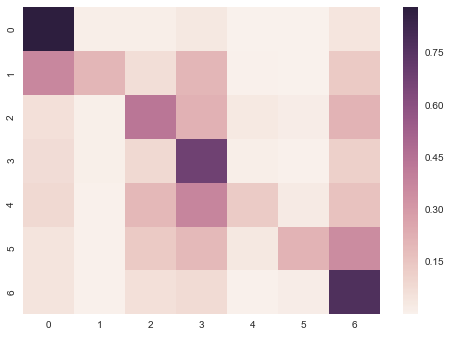

In [9]:
rfc, cm, cm_norm = train_classifier(df_new.copy(), rf, 0.3)

# Feature engineering for improving results
## Feature extraction from Sequential Numbers:
-  I grouped every 20 data point and used mean, std, max and min of the goroup as features representing new data point.

In [11]:
df['id'] = df['sequential number']//20
df = pd.DataFrame()
ndata = 0
for i,s in enumerate(os.listdir('data')):
    if s.endswith('.csv'):
        dftemp = pd.read_csv('data/'+s, \
        names=[ 'sequential number', 'x acceleration', 'y acceleration',
               'z acceleration', 'label'])
        dftemp['id'] = ndata + dftemp['sequential number']
        dftemp['id'] = dftemp['id']//10
        dftemp['member_id'] = i
        ndata += dftemp.shape[0]
        df = pd.concat([df, dftemp])
df = df[df.label != 0]

In [12]:
df.describe()

,sequential number,x acceleration,y acceleration,z acceleration,label,id,member_id
count,1923177.000000,1923177.000000,1923177.000000,1923177.000000,1923177.000000,1923177.000000,1923177.000000
mean,67156.079989,1987.478876,2382.299610,1970.488387,3.890407,96202.577305,8.394850
std,41482.445976,111.340810,100.210725,94.491207,2.439785,55573.730126,4.514254
min,0.000000,282.000000,2.000000,1.000000,1.000000,0.000000,1.000000
25%,32052.000000,1904.000000,2337.000000,1918.000000,1.000000,48079.000000,4.000000
50%,64334.000000,1992.000000,2367.000000,1988.000000,4.000000,96186.000000,9.000000
75%,98440.000000,2076.000000,2412.000000,2032.000000,7.000000,144289.000000,12.000000
max,166740.000000,3828.000000,4095.000000,4095.000000,7.000000,192689.000000,15.000000


In [13]:
# extracting and adding mean, std, min and max of groups as new features
df_new = pd.DataFrame()
df_grouped = df.groupby('id')
funcs =['mean()', 'std()','min()','max()']
for f in funcs:
    df_temp = eval('df_grouped.%s'%f)
    df_temp.columns = df_temp.columns+'_'+f
    df_new = pd.concat([df_new, df_temp], axis=1)
for i in df_new.columns:
    if not (i.startswith('x') | i.startswith('y') | i.startswith('z')):
        df_new.drop(i,axis=1, inplace=True)
df_new[['member_id','label']] = df_grouped.mean()[['member_id','label']]
df_new.label = df_new.label.apply(int)
df_new.member_id = df_new.member_id.apply(int)
df_new.drop('member_id',axis=1,inplace=True)

In [14]:
df_new.head()

,x acceleration_mean(),y acceleration_mean(),z acceleration_mean(),x acceleration_std(),y acceleration_std(),z acceleration_std(),x acceleration_min(),y acceleration_min(),z acceleration_min(),x acceleration_max(),y acceleration_max(),z acceleration_max(),label
id,,,,,,,,,,,,,
0,1595.0,1994.0,1946.9,53.162226,106.088014,92.065737,1502,1829,1831,1667,2215,2153,1
1,1571.8,2042.9,1959.1,41.781974,201.086742,43.393420,1508,1697,1866,1637,2468,2023,1
2,1612.6,2050.9,1996.8,31.777700,79.247082,50.446451,1542,1933,1916,1644,2133,2063,1
3,1608.6,1960.1,2081.0,36.564099,34.696942,36.657575,1561,1922,2011,1694,2032,2142,1
4,1612.0,1944.7,2035.2,19.125318,33.456605,26.046113,1573,1868,2005,1640,1983,2077,1


# Random Forest Classifier

Classifier RandomForestClassifier:
             precision    recall  f1-score   support

          1       0.92      0.94      0.93     24269
          2       0.61      0.30      0.40      1950
          3       0.64      0.56      0.60      8825
          4       0.76      0.89      0.82     14193
          5       0.51      0.24      0.33      2078
          6       0.62      0.31      0.42      1933
          7       0.84      0.88      0.86     23682

avg / total       0.81      0.82      0.81     76930


Confusion Matrix:
[[22778   164   241   319    27     4   736]
 [  642   588   131   323    14     3   249]
 [  381    54  4954  1535   214    88  1599]
 [  223    46   758 12669   104     8   385]
 [   79    10   414   770   503    34   268]
 [   40     8   221   354    55   601   654]
 [  718    87   983   733    64   224 20873]]
Normalized Confusion Matrix:
[[ 0.94  0.01  0.01  0.01  0.    0.    0.03]
 [ 0.33  0.3   0.07  0.17  0.01  0.    0.13]
 [ 0.04  0.01  0.56  0.17  0.02

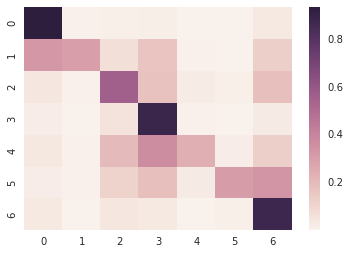

In [106]:
rfc1 = train_classifier(df_new.copy(), rf, 0.4)

# Gradient Boosting Classifier

Classifier GradientBoostingClassifier:
             precision    recall  f1-score   support

          1       0.86      0.91      0.89     24269
          2       0.72      0.08      0.14      1950
          3       0.65      0.37      0.47      8825
          4       0.71      0.89      0.79     14193
          5       0.55      0.10      0.17      2078
          6       0.60      0.14      0.22      1933
          7       0.75      0.87      0.81     23682

avg / total       0.76      0.77      0.74     76930


Confusion Matrix:
[[22070    44   139   406     9     2  1599]
 [  811   151   106   383     5     2   492]
 [  929     5  3237  1871    66    54  2663]
 [  277     6   514 12625    37     3   731]
 [  117     1   337   992   206    29   396]
 [   54     1   198   388    41   263   988]
 [ 1332     3   468  1088    12    86 20693]]
Normalized Confusion Matrix:
[[ 0.91  0.    0.01  0.02  0.    0.    0.07]
 [ 0.42  0.08  0.05  0.2   0.    0.    0.25]
 [ 0.11  0.    0.37  0.21  

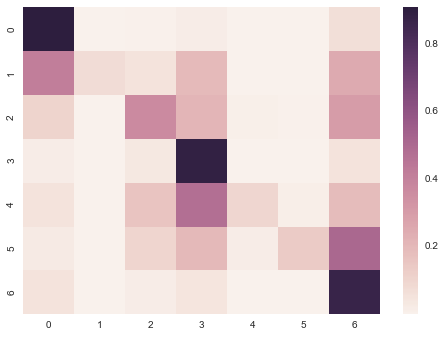

In [15]:
gbc = train_classifier(df_new.copy(), gb, 0.4)

# SVC model

Classifier SVC:
             precision    recall  f1-score   support

          1       0.82      0.85      0.83     54758
          2       0.66      0.02      0.03      4269
          3       0.52      0.08      0.14     19561
          4       0.72      0.88      0.79     32240
          5       0.79      0.01      0.01      4629
          6       0.00      0.00      0.00      4314
          7       0.63      0.88      0.73     53322

avg / total       0.68      0.71      0.65    173093


Confusion Matrix:
[[46378    31   183   854     1     0  7311]
 [ 2040    69   125   753     0     0  1282]
 [ 2606     4  1614  3992     3     0 11342]
 [  942     0   660 28359     3     0  2276]
 [  356     0    34  2362    30     0  1847]
 [  165     1    25   851     0     0  3272]
 [ 4060     0   457  2029     1     1 46774]]
Normalized Confusion Matrix:
[[ 0.85  0.    0.    0.02  0.    0.    0.13]
 [ 0.48  0.02  0.03  0.18  0.    0.    0.3 ]
 [ 0.13  0.    0.08  0.2   0.    0.    0.58]
 [ 0.

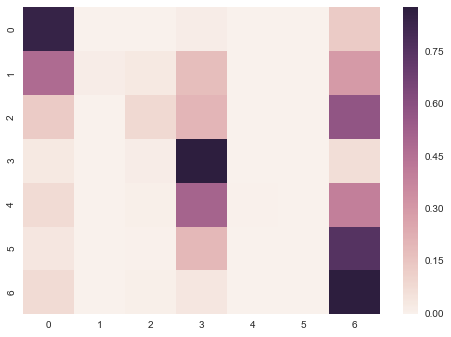

In [17]:
clsvm = train_classifier(df_new.copy(), svm.SVC, 0.9)

# Summary

## Overall, Random forest is performing better